In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

We consider an ocean in a simple rectangular configuration 0 < x < B; 0 < y < L 

In [2]:
# Zonal width of the basin (5,000 km) in m
B = 5000*1000

# Meridional length of the gyre (4,000 km) in m
L = 4000*1000

# Define x and y (m)
x = np.linspace(0,B,100)
y = np.linspace(0,L,100)
xx, yy = np.meshgrid(x, y)

In [3]:
# Constant stratification (s^-1)
N = 5e-3

# Wind stress (N m^-2)
tau_0 = 0.1

# Density (kg m^-3)
rho = 1025

# beta (m^-1 s^-1)
beta = 2e-11

# Coriolis parameter (s^-1)
f_0 = 7e-5;
f = f_0+beta*yy;
#f = 1e-4;

In [4]:
# Zonal wind stress (N m^-2)
tau_x = -tau_0*np.cos(np.pi*yy/L)

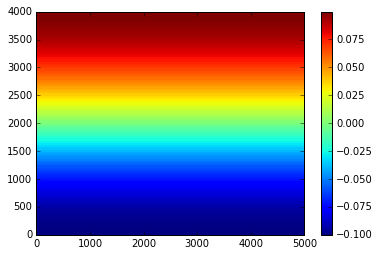

In [5]:
plt.pcolor(x/1000.0,y/1000.0,tau_x)
plt.colorbar()

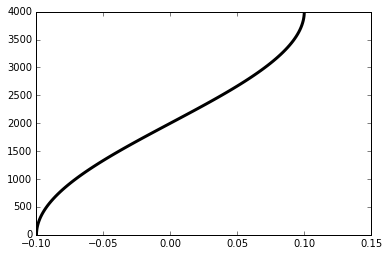

In [6]:
plt.plot(tau_x[:,0], y/1000.0, lw=3, linestyle='-', color='k')

#### Rossby radius of deformation

$$R_n = \frac{1}{f\,\sqrt{\lambda_n}}$$

$$\lambda_n = \int \frac{1}{N^2}\left(\frac{d\Phi_n}{dz}\right)^2\,dz$$
** barotropic:**
$$R_0 = \frac{\sqrt{g\,H}}{f}$$

$$\lambda_0 = \frac{1}{g\,H}$$
** baroclinic (constant N):**
$$R_n = \frac{N\,H}{n\,\pi\,f}$$

$$\lambda_n = \left(\frac{n\,\pi}{N\,H}\right)^2$$

In [7]:
# Gravitational acceleration (m s^-2)
g = 9.81

# Ocean depth (m)
H = 4000

# Barotropic Rossby radius (m)
R_0 = np.sqrt(g*H)/f

In [8]:
# Rossby radius for first baroclinic mode (m)
R_1 = np.sqrt(N*H)/(1*np.pi*f)

In [9]:
# Rossby radius for second baroclinic mode (m)
R_2 = np.sqrt(N*H)/(2*np.pi*f)

Typical values for f = 10$^{-4}$ s$^{-1}$ (Table 8.1 in Olbers, page 213):
- $R_0$ = 2,000 km
- $R_1$ = 10-30 km
- $R_2$ = 2-6 km

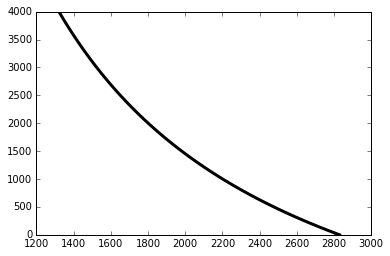

In [10]:
plt.plot(R_0[:,0]/1000.0, y/1000.0, lw=3, linestyle='-', color='k')

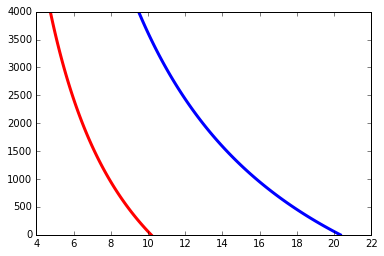

In [11]:
plt.plot(R_1[:,0]/1000.0, y/1000.0, lw=3, linestyle='-', color='b')
plt.plot(R_2[:,0]/1000.0, y/1000.0, lw=3, linestyle='-', color='r')

In [13]:
R = xr.concat([xr.DataArray(R_0,coords=[y,x],dims=['y','x']),
               xr.DataArray(R_1,coords=[y,x],dims=['y','x']),
               xr.DataArray(R_2,coords=[y,x],dims=['y','x'])],dim='n')

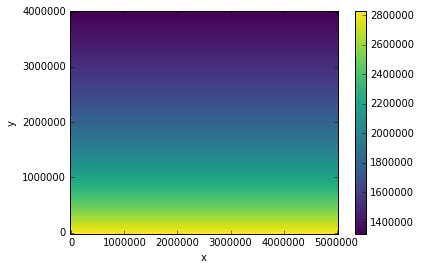

In [14]:
R[0].plot()

**Group velocity**:
$$c_g = -\frac{\beta}{l^2 + R^{-2}}$$

In [15]:
# pi/L (m^-1)
l = np.pi/L

# Group velocity (m/s)
c_g = -(beta/((l**2)+(R**-2)))

# Rigid-lid approximation: R_0 is infinitely large. Replace c_g for n = 0
#c_g[0] = -beta/l**2

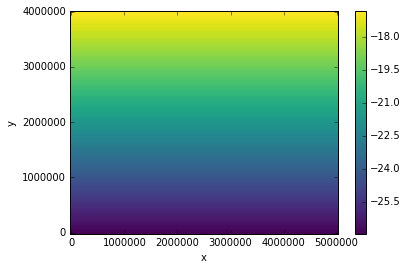

In [16]:
c_g[0].plot()

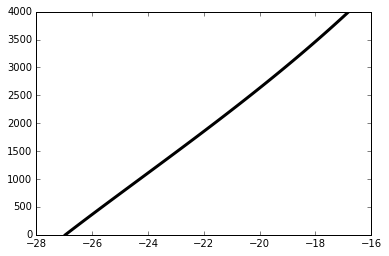

In [17]:
plt.plot(c_g[0,:,0], y/1000.0,lw=3, linestyle='-', color='k')

The wave front propagates with the speed $c_g$, and the position $x_f(t)$ of the front at time $t$ is given by
$$B - x_f = -c_g\,t$$

The time $t_f(x)$ when the front reaches a given position $x$ in the interior is
$$t_f(x) = -\frac{(B-x)}{c_g}$$

In [18]:
# Time of the front at x (s)
t_f = xr.DataArray(-(B-xx),coords=[y,x],dims=['y','x'])/c_g

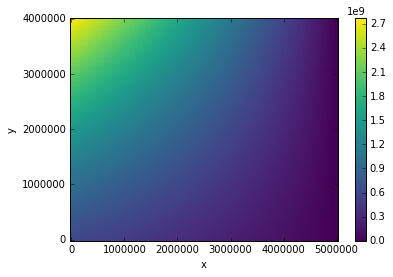

In [19]:
t_f[:,:,1].plot()

**Amplitude function**:
$$\phi(x,t) = \frac{t\,c_g}{\beta}$$
for $t < t_f$

$$\phi(x,t) = -\frac{B - x}{\beta}$$
for $t > t_f$

In [20]:
t = np.zeros([3,100])
for n in [0,1,2]:
    t[n] = np.linspace(0,t_f.max(dim=['x','y'])[n].values,100)
t = np.unique(t)

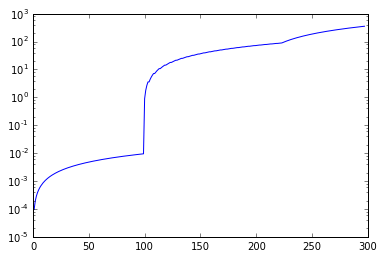

In [21]:
plt.semilogy(t/(60*60*24*365))
#plt.plot(t/(60*60*24*365))

In [22]:
# Amplitude function (m^2 s)
phi = np.zeros([len(y),len(x),len(t),3])

for n in [0,1,2]:
    for i in range (0,len(t)):
        phi[:,:,i,n] = np.where(t[i] < t_f[:,:,n], t[i] * c_g.sel(n=n), -(B-xx))/beta

In [23]:
phi = xr.DataArray(phi,coords=[y,x,t,[0,1,2]],dims=['y','x','t','n'])

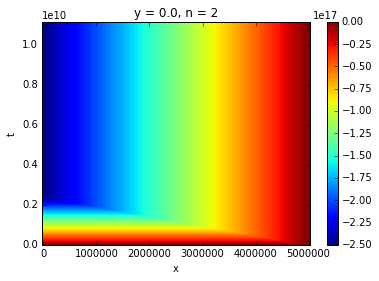

In [24]:
phi[0,:,:,2].T.plot(cmap='jet')

**Eigenfunctions ($\Phi_n$)**
$$\Phi_0(z) = \sqrt{\frac{1}{H}}$$

$$\Phi_n(z) = \sqrt{\frac{2}{H}}\,\cos{\left(\frac{n\,\pi\,z}{H}\right)}$$

In [25]:
z = np.linspace(-H+25,-25,80)

In [26]:
z_edges = np.linspace(-H,0,81)
dz = xr.DataArray(np.diff(z_edges),coords=[z],dims=['z'])

In [27]:
Phi_0 = np.sqrt(1.0/H)*np.ones(len(z))

In [28]:
n = 1
Phi_1 = np.sqrt(2.0/H)*np.cos((n*np.pi*z/H))

In [29]:
n = 2
Phi_2 = np.sqrt(2.0/H)*np.cos((n*np.pi*z/H))

In [30]:
Phi = xr.concat([xr.DataArray(Phi_0,coords=[z],dims=['z']),
                 xr.DataArray(Phi_1,coords=[z],dims=['z']),
                 xr.DataArray(Phi_2,coords=[z],dims=['z'])],dim='n')

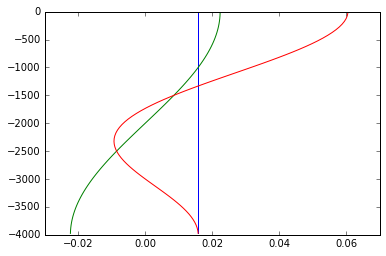

In [31]:
plt.plot(Phi[0],z)
plt.plot(Phi[1],z)
plt.plot(Phi.sum('n'),z)

**Streamfunction**:
$$\psi(x,y,t) = -\phi(x,t)\,s_n\,\tau_0\,l\,\sin({l\,y})$$

$$s_n = \Phi_n(0)$$

In [32]:
sin_ly = xr.DataArray(np.sin(l*yy),coords=[y,x],dims=['y','x'])

In [33]:
# Streamfunction (kg m^-1 s^-1)
psi = -(phi*tau_0*l*sin_ly)*Phi[:,-1]*Phi

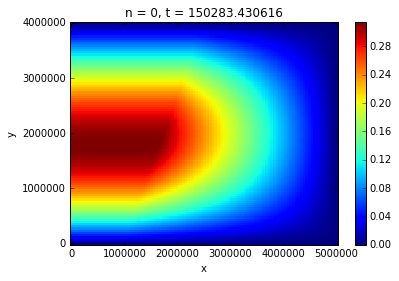

In [34]:
((psi.sel(z=slice(-75,-25))*dz.sel(z=slice(-75,-25))).sum('z')/rho/1e6)[:,:,50,0].plot(cmap='jet')

** Modal sum **

$$\sum_{n=0}^N \psi_n(x,y,t)\,\Phi_n(z) = -\tau_0\,l\,\sin({l\,y})\,\sum_{n=0}^N \phi_n(x,t)\,s_n\,\Phi_n(z)$$

$$\sum_{n=0}^N \psi_n(x,y)\,\Phi_n(z) = \frac{B - x}{\beta}\,\tau_0\,l\,\sin({l\,y})\,\sum_{n=0}^N s_n\,\Phi_n(z)$$

In [35]:
psi_sum = psi.sum('n')

In [36]:
# Streamfunction integrated over some depth range. Convert to Sv (10^6 m^3/s)
psi_full = (psi_sum*dz).sum('z')/rho/1e6
psi_surface = (psi_sum.sel(z=slice(-75,-25))*dz.sel(z=slice(-75,-25))).sum('z')/rho/1e6
psi_mid = (psi_sum.sel(z=slice(-2025,-1975))*dz.sel(z=slice(-2025,-1975))).sum('z')/rho/1e6
psi_bottom = (psi_sum.sel(z=slice(-3975,-3925))*dz.sel(z=slice(-3975,-3925))).sum('z')/rho/1e6

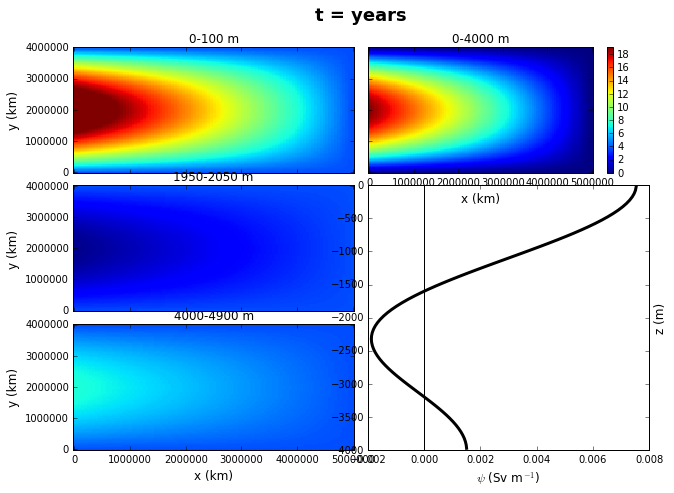

In [37]:
i = -1
f = plt.figure(figsize=(10, 7))
f.subplots_adjust(hspace=0.1, wspace=0.05)
f.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, hspace=0.1, wspace=0.05)
f.suptitle('t = years', fontsize=18, fontweight='bold')
gs = gridspec.GridSpec(3, 2, width_ratios =[1, 1])

ax11 = plt.subplot(gs[0,0])
psi_surface[:,:,i].plot(vmin=-0.5,vmax=2.0,cmap='jet',ax=ax11, add_colorbar=False)
ax11.set_xticklabels([])
ax11.set_xlabel('')
ax11.set_ylabel('y (km)',fontsize=12)
ax11.set_title(r'0-100 m',fontsize=12)

ax21 = plt.subplot(gs[1,0])
psi_mid[:,:,i].plot(vmin=-0.5,vmax=2.0,cmap='jet',ax=ax21, add_colorbar=False)
ax21.set_xticklabels([])
ax21.set_xlabel('')
ax21.set_ylabel('y (km)',fontsize=12)
ax21.set_title(r'1950-2050 m',fontsize=12)

ax31 = plt.subplot(gs[2,0])
psi_bottom[:,:,i].plot(vmin=-0.5,vmax=2.0,cmap='jet',ax=ax31, add_colorbar=False)
ax31.set_xlabel('x (km)',fontsize=12)
ax31.set_ylabel('y (km)',fontsize=12)
ax31.set_title(r'4000-4900 m',fontsize=12)

ax12 = plt.subplot(gs[0,1])
psi_full[:,:,i].plot(cmap='jet',ax=ax12)
ax12.set_yticklabels([])
ax12.set_xlabel('x (km)',fontsize=12)
ax12.set_ylabel('')
ax12.set_title(r'0-4000 m',fontsize=12)

ax22 = plt.subplot(gs[1:,1])
ax22.axvline(x=0, ymin=0, ymax=1, linewidth=1, color = 'k')
ax22.plot(psi_sum.mean(dim=['x','y'])[i]/rho/1e6,z,linewidth=3,color='k')
ax22.yaxis.set_label_position('right')
ax22.set_xlabel(r'$\psi$ (Sv m$^{-1}$)',fontsize=12)
ax22.set_ylabel('z (m)',fontsize=12)

plt.show()